In [1]:
import matplotlib.pyplot as plt
from cryptovision.tools import (
    CryptoVisionAI, 
    image_directory_to_pandas, 
    split_image_dataframe, 
    tf_dataset_from_pandas
)

import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

def plot_og_saliency_lime_maps(
    original_image, 
    saliency_map, 
    lime_map, 
    predictions, 
    confidences,
    num_features=3,
    alpha=0.5,
    figure_size=(15, 6),
):
    """
    Plot original image, saliency map, and LIME map side by side with a legend.

    Parameters:
    - original_image (PIL.Image or np.ndarray): The original input image.
    - saliency_map (np.ndarray): The generated saliency map.
    - lime_map (tuple): The LIME map result as (image, mask).
    - predictions (tuple): Predictions for family, genus, and species.
    - confidences (tuple): Confidence scores for family, genus, and species.
    - figure_size (tuple): Size of the figure.
    """
    # Convert original image to numpy array if needed
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)

    # Extract LIME image and mask from tuple
    temp, mask = lime_map.get_image_and_mask(
        lime_map.top_labels[0],
        num_features=num_features,
        negative_only=True,
        positive_only=False,
        hide_rest=True,
    )

    # Plot the three maps
    fig, axes = plt.subplots(1, 3, figsize=figure_size)

    # Plot Original Image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot Saliency Map
    axes[1].imshow(original_image)
    axes[1].imshow(saliency_map[0], cmap='jet', alpha=alpha)
    axes[1].set_title("Saliency Map")
    axes[1].axis("off")

    # Plot LIME Map
    axes[2].imshow(original_image)
    axes[2].imshow(mark_boundaries(temp, mask), cmap='jet', alpha=alpha)
    axes[2].set_title("LIME Map")
    axes[2].axis("off")

    # Add a legend with predictions and confidences
    pred_text = (
        f"Family: {predictions[0]} ({confidences[0]*100:.2f}%)\n"
        f"Genus: {predictions[1]} ({confidences[1]*100:.2f}%)\n"
        f"Species: {predictions[2]} ({confidences[2]*100:.2f}%)"
    )

    fig.text(0.5, 0.05, pred_text, ha='center', fontsize=16, bbox={"facecolor": "white", "alpha": 0.5, "pad": 10})
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


2025-01-28 11:25:38.591 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
IMAGES_DATASET_PATH = '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images'
#TRAINED_MODEL_PATH = '/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras'
#TRAINED_MODEL_PATH = '/Users/leonardo/Documents/Projects/cryptovision/models/saliency_maps_models/model_epoch_20.keras'


SEED = 42
VAL_SIZE = 0.15
TEST_SIZE = 0.15
BATCH_SIZE = 64

df_images = image_directory_to_pandas(IMAGES_DATASET_PATH)

train_df, val_df, test_df = split_image_dataframe(
    df_images,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE,
    random_state=SEED,
)

test_df.reset_index(drop=True, inplace=True)

family_labels = sorted(df_images['family'].unique())
genus_labels = sorted(df_images['genus'].unique())
species_labels = sorted(df_images['species'].unique())

test_ds, _, _, _ = tf_dataset_from_pandas(
    test_df, batch_size=BATCH_SIZE, image_size=(128, 128), shuffle=False)

2025-01-28 11:27:32.330296: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-28 11:27:32.330331: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-01-28 11:27:32.330338: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-01-28 11:27:32.330621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-28 11:27:32.330632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


--- model_epoch_00.keras ---
--- model_epoch_01.keras ---
--- model_epoch_05.keras ---
--- model_epoch_10.keras ---
--- model_epoch_15.keras ---
--- model_epoch_20.keras ---


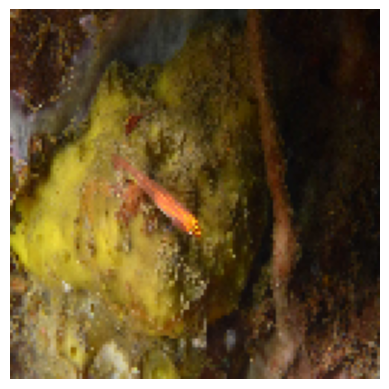

In [56]:
import os

smaps = []
df_eviota = test_df[test_df['genus'] == 'Eviota']
idx = np.random.randint(0, df_eviota.shape[0])
img_path = '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00002.jpeg'

for model_name in sorted(os.listdir('/Users/leonardo/Documents/Projects/cryptovision/models/RN152v2_299_v2501.27.1855')):
    if not model_name.endswith('.keras'):
        continue
    
    print(f"--- {model_name} ---")
    model_path = os.path.join('/Users/leonardo/Documents/Projects/cryptovision/models/saliency_maps_models', model_name)
    
    ai = CryptoVisionAI(
        model_path=model_path,
        family_names=family_labels,
        genus_names=genus_labels,
        species_names=species_labels,
    )
    
    sample = df_eviota.iloc[idx]
    
    pred = ai.predict(img_path, top_k=3)
    #pred = ai.predict(sample['image_path'], top_k=3)
    
    smap = ai.generate_saliency_map('species', smooth_noise= .2, smooth_samples=100)
    
    smaps.append(smap)
    
    #print(f"""
    #    --- True Label ---
    #    \t Family: {sample['family']}
    #    \t Genus: {sample['genus']}
    #    \t Species: {sample['species']}
    #    
    #    --- CryptoVisionAI Prediction ---
    #    \t Family: {pred[0]} ({ai.confidence[0]*100:.2f}%)
    #    \t Genus: {pred[1]} ({ai.confidence[1]*100:.2f}%)
    #    \t Species: {pred[2]} ({ai.confidence[2]*100:.2f}%)   
    #""")
    
plt.imshow(ai.image)
plt.axis('off')
plt.show()

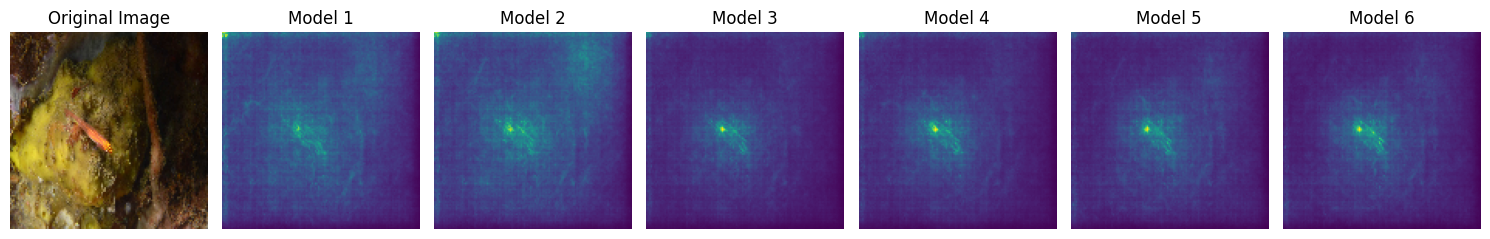

In [57]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 7, 1)
plt.title("Original Image")
plt.imshow(ai.image)
plt.axis('off')

for i, smap in enumerate(smaps):
    plt.subplot(1, 7, i+2)
    plt.title(f"Model {i+1}")
    plt.imshow(smap[0])
    plt.axis('off')

plt.tight_layout()
plt.show()